# Coursework 2: Generative Models

## Instructions

### Submission 
Please submit one zip file on cate - *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells**
2. Your trained VAE model as *VAE_model.pth*
3. Your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*


### Training
Training the GAN will take quite a long time (multiple hours), please refer to the 4 GPU options detailed in the logistics lecture. Some additional useful pointers:
* PaperSpace [guide if you need more compute](https://hackmd.io/@afspies/S1stL8Qnt)
* Lab GPUs via SSH.  The VSCode Remote Develop extension is recommended for this. For general Imperial remote working instructions see [this post](https://www.doc.ic.ac.uk/~nuric/teaching/remote-working-for-imperial-computing-students.html). You'll also want to [setup your environment as outlined here](https://hackmd.io/@afspies/Bkd7Zq60K).
* Use Colab and add checkpointing to the model training code; this is to handle the case where colab stops a free-GPU kernel after a certain number of hours (~4).
* Use Colab Pro - If you do not wish to use PaperSpace then you can pay for Colab Pro. We cannot pay for this on your behalf (this is Google's fault).


### Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions)

### General
You can feel free to add architectural alterations / custom functions outside of pre-defined code blocks, but if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

<font color="orange">**The deadline for submission is Monday, 26 Feb by 6 pm** </font>

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [77]:
!pip install -q torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

fatal: destination path 'icl_dl_cw2_utils' already exists and is not an empty directory.


Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [78]:
# Initialization Cell
WORKING_ENV = 'LABS' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
USERNAME = 'mdh323' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    dl_cw2_repo_path = 'dl_cw2/' # path in your gdrive to the repo
    content_path = f'/content/drive/MyDrive/{dl_cw2_repo_path}' # path to gitrepo in gdrive after mounting
    data_path = './data/' # save the data locally
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw2/' # You may want to change this
    data_path = f'/vol/bitbucket/{USERNAME}/dl/'
    # Your python env and training data should be on bitbucket
    if 'vol/bitbucket' not in content_path or 'vol/bitbucket' not in data_path:
        import warnings
        warnings.warn(
           'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
           )
elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = '/notebooks/'
    data_path = './data/'
    
elif WORKING_ENV == 'SAGEMAKER':
    content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/dl/'
    data_path = f'{content_path}data/'

else:
  raise NotImplementedError()

content_path = Path(content_path)

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points. 

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. More marks are awarded for using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [79]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
### Hyper-parameter selection


In [95]:
# Necessary Hyperparameters 
num_epochs = 25
learning_rate = 1e-3
batch_size = 128
latent_dim = 8

# Additional Hyperparameters 
beta = 2.0
capacity = 64

# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(), # rescales 0-255 into 0-1 range
    lambda x: x.round(),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [83]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

# Get also full data for evaluating the model at the end of every epoch
def get_all_data(loader):
    data = []
    for image, _ in loader:
        data.append(image)
    return torch.cat(data, dim=0)

training_data = get_all_data(loader_train)
training_data = training_data.to(device)
testing_data = get_all_data(loader_test)
testing_data = testing_data.to(device)

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [84]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim=latent_dim, init_channels=capacity):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Set the convolution hyperparameters
        # Latent dim set to 16 by default
        kernel_size = 4
        image_channels = 1 # due to gray scale we have no RGB
        stride = 2
        padding = 1
        
        # Encode layers
        self.conv1 = nn.Conv2d(image_channels, init_channels, kernel_size, stride, padding) # out: capacity x 14 x 14
        self.bn1 = nn.BatchNorm2d(init_channels)
        self.conv2 = nn.Conv2d(init_channels, init_channels*2, kernel_size, stride, padding) # out: capacity x 7 x 7
        self.bn2 = nn.BatchNorm2d(init_channels*2)
        self.fc_mu = nn.Linear(init_channels*2*7*7, latent_dim)
        self.fc_logvar = nn.Linear(init_channels*2*7*7, latent_dim)
        
        # Decode layers 
        self.fc = nn.Linear(latent_dim, out_features=init_channels*2*7*7) # match mu and logvar in reverse
        self.conv3 = nn.ConvTranspose2d(init_channels*2, init_channels, kernel_size, stride, padding)
        self.bn3 = nn.BatchNorm2d(init_channels)
        self.conv4 = nn.ConvTranspose2d(init_channels, 1, kernel_size, stride, padding)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1) # flatten it out
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # This is the reparameterisation trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sample = (eps * std) + mu # here the sampling takes place
        return sample
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = self.fc(z)
        z = z.view(z.size(0), capacity*2, 7, 7)
        z = F.relu(self.bn3(self.conv3(z)))
        z = torch.sigmoid(self.conv4(z)) # sigmoid for last layer due to BCE
        return z
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Pass the input through the encoder
        x_mu, x_logvar = self.encode(x)
        
        # Get the latent vector through reparameterisation trick
        latent = self.reparametrize(x_mu, x_logvar)
        
        # Decode and return outputs
        reconstruction = self.decode(latent)
        
        return reconstruction, x_mu, x_logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 421777
VAE(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_mu): Linear(in_features=6272, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=6272, out_features=8, bias=True)
  (fc): Linear(in_features=8, out_features=6272, bias=True)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


--- 

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [85]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # This functions sums the reconstruction loss (BCELoss) and KL-Divergence. 
        # KL-D = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # We use BCE as our result is scaled from 0 to 1 with a sigmoid.
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction = 'sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss, kl_div
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################

def training_loop(learn_rate, num_epochs, loader, beta_val, loud_print = False, save_recons = False, save_model = False):
    # Create lists to store the results
    train_total_loss = []
    train_total_RL = []
    train_total_KL = []

    test_total_loss = []
    test_total_RL = []
    test_total_KL = []
    
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    for epoch in range(num_epochs):   
        model.train() # start training
        total_loss= 0
        with tqdm.tqdm(loader, unit="batch") as tepoch:
            for batch_idx, (data, _) in enumerate(tepoch):   
                data = data.to(device)
                optimizer.zero_grad()
                # Forward pass
                reconstruction, mu, logvar = model(data)
                # Calculate loss
                loss_RL, loss_KL = loss_function_VAE(reconstruction, data, mu, logvar)
                loss = (loss_RL + beta_val*loss_KL)
                # Back prop
                loss.backward()
                total_loss += loss.item()
                optimizer.step()
                
                if loud_print:
                    if batch_idx % 20 == 0:
                        tepoch.set_description(f"Epoch {epoch}")
                        tepoch.set_postfix(loss=loss.item()/len(data))
            
            print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, total_loss / len(loader_train.dataset)))        
            if save_recons:
                recon, _, _ = model(fixed_input.to(device))
                recon = denorm(recon.cpu()) # denorm in case we need to
                save_image(recon, content_path/'CW_VAE/reconstructed_epoch_{}.png'.format(epoch))
                    
            # Next, get train and test losses after latest epoch of training
            with torch.no_grad():
                ## Train losses at the end of teh epoch
                recon_train, mu_train, logvar_train = model(training_data)
                train_RL, train_KL = loss_function_VAE(recon_train, training_data, mu_train, logvar_train)
                
                train_loss_RL = train_RL.item()
                train_loss_KL = beta_val*train_KL.item()
                train_loss = train_loss_RL + train_loss_KL

                train_total_loss.append(train_loss/len(training_data))
                train_total_RL.append(train_loss_RL/len(training_data))
                train_total_KL.append(train_loss_KL/len(training_data))
                if loud_print:
                    print('Train set loss: {:.4f}'.format(train_total_loss[-1]))
                
                ## Test losses at the end of the epoch
                recon_test, mu_test, logvar_test = model(testing_data)
                test_RL, test_KL = loss_function_VAE(recon_test, testing_data, mu_test, logvar_test)
                
                test_loss_RL = test_RL.item()
                test_loss_KL = beta_val*test_KL.item()
                test_loss = test_loss_RL + test_loss_KL

                test_total_loss.append(test_loss/len(testing_data))
                test_total_RL.append(test_loss_RL/len(testing_data))
                test_total_KL.append(test_loss_KL/len(testing_data))
                if loud_print:
                    print('Test set loss: {:.4f}'.format(test_total_loss[-1]))
                
    if save_model:
        # save the model if it's the last epoch
        if epoch == num_epochs - 1:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    f'{content_path}/CW_VAE/VAE_model.pth')
                
    losses = [train_total_loss, train_total_RL, train_total_KL,
              test_total_loss, test_total_RL, test_total_KL]
    return losses

# Get loss curves across different betas
losses_beta_one_tenth = training_loop(learn_rate = learning_rate, num_epochs=num_epochs, loader= loader_train, beta_val=0.1)
losses_beta_one = training_loop(learn_rate = learning_rate, num_epochs=num_epochs, loader= loader_train, beta_val=1.0)
losses_beta_two = training_loop(learn_rate = learning_rate, num_epochs=num_epochs, loader= loader_train, beta_val=2.0)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.33batch/s]


epoch [1/25], loss:128.9036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.53batch/s]


epoch [2/25], loss:95.3209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.49batch/s]


epoch [3/25], loss:90.2808


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.09batch/s]


epoch [4/25], loss:86.9610


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.92batch/s]


epoch [5/25], loss:84.3469


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.84batch/s]


epoch [6/25], loss:82.5334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.39batch/s]


epoch [7/25], loss:80.9741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.45batch/s]


epoch [8/25], loss:79.6826


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.22batch/s]


epoch [9/25], loss:78.5446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.46batch/s]


epoch [10/25], loss:77.7146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.14batch/s]


epoch [11/25], loss:76.8309


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.71batch/s]


epoch [12/25], loss:75.9763


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.08batch/s]


epoch [13/25], loss:75.3560


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.12batch/s]


epoch [14/25], loss:74.7316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.33batch/s]


epoch [15/25], loss:74.2765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.98batch/s]


epoch [16/25], loss:73.7544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.65batch/s]


epoch [17/25], loss:73.3056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.22batch/s]


epoch [18/25], loss:72.8492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.15batch/s]


epoch [19/25], loss:72.4999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.78batch/s]


epoch [20/25], loss:72.1423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.62batch/s]


epoch [21/25], loss:71.8581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.81batch/s]


epoch [22/25], loss:71.5492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.88batch/s]


epoch [23/25], loss:71.3156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.49batch/s]


epoch [24/25], loss:71.1044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.75batch/s]


epoch [25/25], loss:70.7958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.95batch/s]


epoch [1/25], loss:141.2119


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.44batch/s]


epoch [2/25], loss:112.7112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.49batch/s]


epoch [3/25], loss:107.6255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.19batch/s]


epoch [4/25], loss:104.4126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.35batch/s]


epoch [5/25], loss:102.4425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.21batch/s]


epoch [6/25], loss:100.8270


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.83batch/s]


epoch [7/25], loss:99.5459


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.82batch/s]


epoch [8/25], loss:98.5536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.37batch/s]


epoch [9/25], loss:97.5629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.49batch/s]


epoch [10/25], loss:96.9569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.25batch/s]


epoch [11/25], loss:96.2597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.93batch/s]


epoch [12/25], loss:95.6587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.14batch/s]


epoch [13/25], loss:95.0767


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.37batch/s]


epoch [14/25], loss:94.6363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.51batch/s]


epoch [15/25], loss:94.1588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.15batch/s]


epoch [16/25], loss:93.8248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.03batch/s]


epoch [17/25], loss:93.4361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.96batch/s]


epoch [18/25], loss:93.1589


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.35batch/s]


epoch [19/25], loss:92.8477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.07batch/s]


epoch [20/25], loss:92.5721


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.87batch/s]


epoch [21/25], loss:92.3037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.72batch/s]


epoch [22/25], loss:92.0259


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.49batch/s]


epoch [23/25], loss:91.8972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.81batch/s]


epoch [24/25], loss:91.6152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.71batch/s]


epoch [25/25], loss:91.4559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 63.88batch/s]


epoch [1/25], loss:159.1616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.32batch/s]


epoch [2/25], loss:128.2104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.11batch/s]


epoch [3/25], loss:123.4632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.95batch/s]


epoch [4/25], loss:120.9639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.71batch/s]


epoch [5/25], loss:119.2263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.19batch/s]


epoch [6/25], loss:117.7214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.18batch/s]


epoch [7/25], loss:116.5889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.24batch/s]


epoch [8/25], loss:115.6036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.58batch/s]


epoch [9/25], loss:114.6933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.49batch/s]


epoch [10/25], loss:114.0376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.32batch/s]


epoch [11/25], loss:113.4228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.46batch/s]


epoch [12/25], loss:112.7262


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.74batch/s]


epoch [13/25], loss:112.2626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.07batch/s]


epoch [14/25], loss:111.6789


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.06batch/s]


epoch [15/25], loss:111.4017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.26batch/s]


epoch [16/25], loss:110.9067


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.01batch/s]


epoch [17/25], loss:110.5699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.74batch/s]


epoch [18/25], loss:110.2681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.06batch/s]


epoch [19/25], loss:109.8973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.64batch/s]


epoch [20/25], loss:109.6606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.25batch/s]


epoch [21/25], loss:109.3277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 67.56batch/s]


epoch [22/25], loss:109.1628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.87batch/s]


epoch [23/25], loss:109.0017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.77batch/s]


epoch [24/25], loss:108.7009


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.80batch/s]


epoch [25/25], loss:108.5388


### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


**YOUR ANSWER**

The total loss comprises two parts. First, there is the reconstruction loss, and this measures how well the VAE can reconstruct the input data by correctly categorising pixels. As part of my preprocessing, the inputs to my model are transformed into digits rounded to zero or one. A zero represents a black pixel and a one a white pixel. Therefore, I consider each pixel a Bernoulli observation and the goal of the model is to categorise each pixel as a zero or one, black or white. In my implementation I use a "sum" reduction meaning that the loss is calculated for each element in the batch and then added together. This is useful in the context of my beta value to prevent extreme posterior collapse. 

The second part of the loss function is the Kullback Lieblers Divergance (KLD) and this regularises the encoder by comparing the distribution of the encoded latent varaibles to the prior distribution (in this case a standard normal). This is to ensure that the latent space has the desirable properties such as continuity and completeness which are important for generative tasks. 

Finally, there is also the beta hyperparameter which determines how these two loss components are weighted, and therefore how our parameters are optimised. Setting beta to less than one will make our model place less emphasis on generation and more on reconstruction, as the latent space becomes more expressive but less regularised. By contrast, setting the beta to more than one places strong weight on latent space regularisation, encouraging our latent variables to match the prior (normal) distribution. However, this can lead to worse reconstruction performance because the model prioritises the organisation of the latent space over accurately reconstructing each input. Setting beta to one simply returns the standard VAE loss where there is a balance between reconstruction loss and latent space normalisation. It is this beta hyperparameter which relates the loss function to disentanglement in the latent space.

The tradeoff between different values of beta is reflected in the loss curves below. 

<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

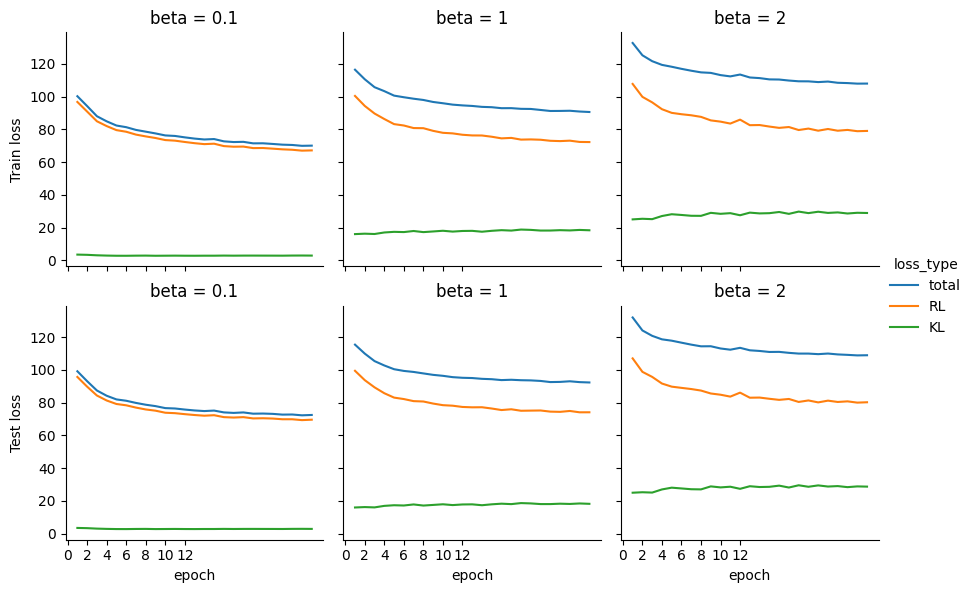

In [86]:
# *CODE FOR PART 1.2a IN THIS CELL*

# Collect results ready to plot loss curves
def convert_results_to_df(list_name, dataset_type, list_idx, loss_type, beta_val):
    df = pd.DataFrame({
        'dataset': [dataset_type]*len(list_name[list_idx]),
        'epoch': range(1, len(list_name[list_idx])+ 1),
        'loss_type': [loss_type]*len(list_name[list_idx]),
        'beta': [beta_val]*len(list_name[list_idx]),
        'loss': list_name[list_idx]  
    })
    return df

# Beta = 0.1    
df1 = convert_results_to_df(losses_beta_one_tenth, 'train', 0, 'total', '0.1')
df2 = convert_results_to_df(losses_beta_one_tenth, 'train', 1, 'RL',    '0.1')
df3 = convert_results_to_df(losses_beta_one_tenth, 'train', 2, 'KL',    '0.1')
df4 = convert_results_to_df(losses_beta_one_tenth, 'test',  3, 'total', '0.1')
df5 = convert_results_to_df(losses_beta_one_tenth, 'test',  4, 'RL',    '0.1')
df6 = convert_results_to_df(losses_beta_one_tenth, 'test',  5, 'KL',    '0.1')

# Beta = 1.0
df7 =  convert_results_to_df(losses_beta_one, 'train', 0, 'total', '1')
df8 =  convert_results_to_df(losses_beta_one, 'train', 1, 'RL',    '1')
df9 =  convert_results_to_df(losses_beta_one, 'train', 2, 'KL',    '1')
df10 = convert_results_to_df(losses_beta_one, 'test',  3, 'total', '1')
df11 = convert_results_to_df(losses_beta_one, 'test',  4, 'RL',    '1')
df12 = convert_results_to_df(losses_beta_one, 'test',  5, 'KL',    '1')

# Beta = 2.0
df13 = convert_results_to_df(losses_beta_two, 'train', 0, 'total', '2')
df14 = convert_results_to_df(losses_beta_two, 'train', 1, 'RL',    '2')
df15 = convert_results_to_df(losses_beta_two, 'train', 2, 'KL',    '2')
df16 = convert_results_to_df(losses_beta_two, 'test',  3, 'total', '2')
df17 = convert_results_to_df(losses_beta_two, 'test',  4, 'RL',    '2')
df18 = convert_results_to_df(losses_beta_two, 'test',  5, 'KL',    '2')

losses_by_beta = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8,
                            df9, df10, df11, df12, df13, df14, df15,
                            df16, df17, df18], axis = 0)
losses_by_beta = losses_by_beta.reset_index(drop = True)

# Draw a facet plot
loss_curves = sns.relplot(losses_by_beta, x = 'epoch', y = 'loss', hue = 'loss_type', 
                          col = 'beta', row = 'dataset', kind='line', height=3, aspect=1)
for i, ax in enumerate(loss_curves.axes.flatten()):
    if i < len(loss_curves.axes):  # First row
        ax.set_ylabel('Train loss')
    else:  # Second row
        ax.set_ylabel('Test loss')
    new_title = ax.get_title().split("|")[-1].strip()
    ax.set_title(new_title)
    ax.set_xticks(range(0, 13, 2))  

## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


In [87]:
# For now let's settle on a model with our hyperparameter beta chosen above
beta_val = beta
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Choose the model with beta = our hyperparameter choice
for epoch in range(num_epochs):   
        model.train() # start training
        total_loss= 0
        with tqdm.tqdm(loader_train, unit="batch") as tepoch:
            for batch_idx, (data, _) in enumerate(tepoch):   
                data = data.to(device)
                optimizer.zero_grad()
                # Forward pass
                reconstruction, mu, logvar = model(data)
                # Calculate loss
                loss_RL, loss_KL = loss_function_VAE(reconstruction, data, mu, logvar)
                loss = (loss_RL + beta_val*loss_KL)
                # Back prop
                loss.backward()
                total_loss += loss.item()
                optimizer.step()
                
                if batch_idx % 20 == 0:
                    tepoch.set_description(f"Epoch {epoch}")
                    tepoch.set_postfix(loss=loss.item()/len(data))
            
            print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, total_loss / len(loader_train.dataset)))        
            recon, _, _ = model(fixed_input.to(device))
            recon = denorm(recon.cpu()) # denorm in case we need to
            save_image(recon, content_path/'CW_VAE/reconstructed_epoch_{}.png'.format(epoch))   
                
        # save the model if it's the last epoch
        if epoch == num_epochs - 1:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    f'{content_path}/CW_VAE/VAE_model.pth')

Epoch 0:   0%|                                                                                                                                                                              | 0/469 [00:00<?, ?batch/s, loss=770]

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.81batch/s, loss=134]


epoch [1/25], loss:160.2445


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.50batch/s, loss=125]


epoch [2/25], loss:128.2042


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.26batch/s, loss=121]


epoch [3/25], loss:123.2096


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.68batch/s, loss=114]


epoch [4/25], loss:120.3101


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.49batch/s, loss=121]


epoch [5/25], loss:118.3129


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.79batch/s, loss=112]


epoch [6/25], loss:116.9507


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.90batch/s, loss=111]


epoch [7/25], loss:115.7134


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.95batch/s, loss=115]


epoch [8/25], loss:114.9175


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.24batch/s, loss=113]


epoch [9/25], loss:113.9659


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.80batch/s, loss=108]


epoch [10/25], loss:113.1927


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.99batch/s, loss=105]


epoch [11/25], loss:112.7112


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.08batch/s, loss=113]


epoch [12/25], loss:112.0399


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.89batch/s, loss=107]


epoch [13/25], loss:111.7263


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.20batch/s, loss=104]


epoch [14/25], loss:111.1895


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.96batch/s, loss=116]


epoch [15/25], loss:110.7379


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.25batch/s, loss=116]


epoch [16/25], loss:110.3951


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.51batch/s, loss=101]


epoch [17/25], loss:110.0031


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.67batch/s, loss=107]


epoch [18/25], loss:109.7496


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.59batch/s, loss=108]


epoch [19/25], loss:109.4286


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 66.97batch/s, loss=109]


epoch [20/25], loss:109.1041


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.39batch/s, loss=110]


epoch [21/25], loss:109.0352


Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.18batch/s, loss=106]


epoch [22/25], loss:108.7759


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.63batch/s, loss=111]


epoch [23/25], loss:108.4646


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.87batch/s, loss=108]


epoch [24/25], loss:108.2604


Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 62.94batch/s, loss=110]

epoch [25/25], loss:108.1335


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


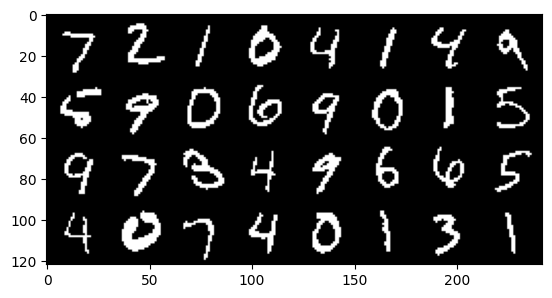

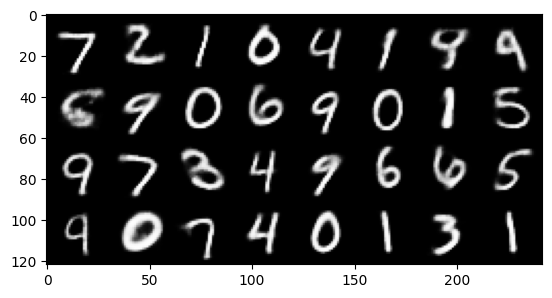

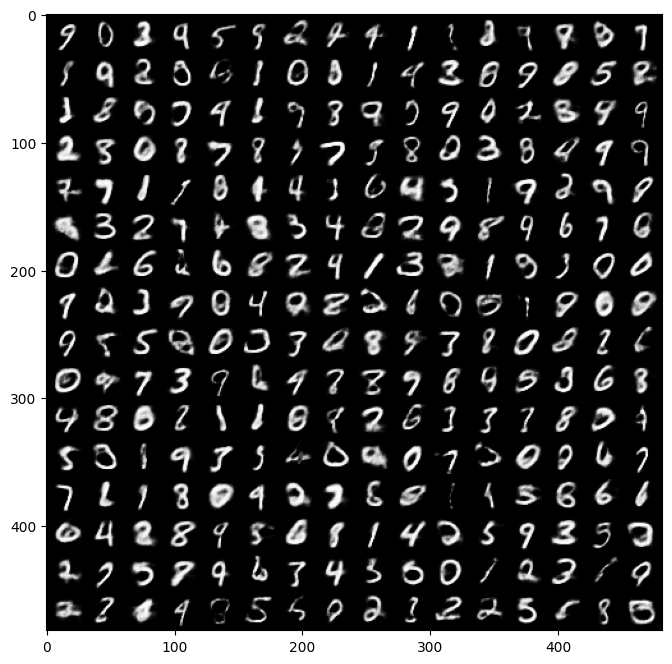

In [88]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch = model(fixed_input.to(device))
    recon_batch = recon_batch[0].cpu()
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 256 # account for 4x4 convolution
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions: 

* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?

* Can you intuitively explain if this behaviour is desirable? 

* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)?

**YOUR ANSWER**

1. Behaviour of log-likelihood loss and the KL loss

The trend on both train and test datasets shows that total loss decreases over epochs. As this total loss decreases over both sets, this suggests that there isn't an issue of over-fitting and so there is no need for early stopping. Furthermore, I notice that as the log-likelihood loss (reconstruction loss) decreases, the KL loss gently increases as the epochs progress. This suggests that as the model gets better at reconstructing the input data, this comes at the cost to the regularity of the latent space. This means that the model's latent space for z might start to deviate more from the standard normal distribution, and so the model is better at capturing details specific to the dataset but at the cost of generalisation.

2. Inuition as to whether this be desirable

On the one hand, it is important for the latent space to be well-structured so that different numbers can be effectively separated for reconstruction. Thus we want our reconstruction loss to be low. On the other hand, the KLD tried to coerce the structure of the latent space onto a standard normal, which is helpful for generation. From the loss curves, it appears that a lot of reconstruction loss can be improved at the expense of a small amount of KLD loss, so this seemed a worthwhile tradeoff. Relatedly, when considering total loss, I'd suggest that the goal shouldn't be to minimise it altogether. This is because you can get a lot lower reconstruction loss relative to KL-loss gain simply by setting beta to zero, but this is not reflective of the best model necessarily. This is why I chose a higher value of beta, even though it raises the total loss.

3. Posterior collapse and whether it was observed during training

Posterior collapse is when the variational posterior distribution q(z|x) (the encoder's output) collapses to the prior distribution p(z). This means that the encoder stops encoding useful information about the input data x into the latent variables z. This defeats the goal of the VAE, which is to learn effective representations of higher dimensional data in lower dimensional space. Posterior collapse can occur when the beta value is very high (e.g. 10 and above). In this case, the network converges to its local minimum and the output converges to its mean, which is a filled grey zero. To experiment, I tried some very high beta values and saw my sample grid mostly filled with non-distinct grey zeros. (This is visualised in one of the plots in the next section). To mitigate this, I lowered the beta value by experimenting with several betas. There are also other ways to mitigate it which I did not try, such as data augmentation (improving the diversity and complexity of input data) and adjusting the model architecture to use a less powerful decoder and more powerful encoder. 

---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn. 

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [96]:
# *CODE FOR PART 1.3a IN THIS CELL

# Define a model training loop so we can easily get several models for varying beta
def get_model(beta_val, learn_rate=learning_rate, num_epochs=num_epochs):
    model = VAE(latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    for epoch in range(num_epochs):   
            model.train() # start training
            total_loss= 0
            with tqdm.tqdm(loader_train, unit="batch") as tepoch:
                for batch_idx, (data, _) in enumerate(tepoch):   
                    data = data.to(device)
                    optimizer.zero_grad()
                    # Forward pass
                    reconstruction, mu, logvar = model(data)
                    # Calculate loss
                    loss_RL, loss_KL = loss_function_VAE(reconstruction, data, mu, logvar)
                    loss = (loss_RL + beta_val*loss_KL)
                    # Back prop
                    loss.backward()
                    total_loss += loss.item()
                    optimizer.step()
                    
                    if batch_idx % 20 == 0:
                        tepoch.set_description(f"Epoch {epoch}")
                        tepoch.set_postfix(loss=loss.item()/len(data))
                        
    return model

def tsne_data(test_input, test_input_labs, model, beta_val):
    with torch.no_grad():
        x_mu, x_logvar = model.encode(test_input)
        z = model.reparametrize(x_mu, x_logvar)
        z = z.cpu()
        z = z.numpy()
        
    tsne = TSNE(n_components=2)
    z_embedded = tsne.fit_transform(z)

    df = pd.DataFrame(z_embedded)
    df.columns = ["dim1", "dim2"]
    df["labels"] = test_input_labs
    df["beta"] = beta_val
    return df
        

test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
test_features, test_labels = next(iter(test_dataloader))
test_features = test_features.to(device)
test_features = test_features.view(10000, -1, 28, 28)

m1_beta_zero = get_model(0)
m1_beta_two = get_model(2.0)
m1_beta_ten = get_model(10.0)

beta_zero = tsne_data(test_features, test_labels, m1_beta_zero, '0')
beta_two = tsne_data(test_features, test_labels, m1_beta_two, '2')
beta_ten = tsne_data(test_features, test_labels, m1_beta_ten, '10')

learned_representations = pd.concat([beta_zero, beta_two, beta_ten], axis = 0)
learned_representations = learned_representations.reset_index(drop = True)

Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 64.53batch/s, loss=179]


In [ ]:
# Interactive Visualization - Code Provided
#test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
#""" Inputs to the function are
#        z_embedded - Embedded X, Y positions for every point in test_dataloader
#        test_dataloader - dataloader with batchsize set to 10000
#        num_points - number of points plotted (will slow down with >1k)
#"""
#plot_tsne(z_embedded, test_dataloader, num_points=1000)

# Comment -- I tried running this but got the altair error others seemed to get. Sorry!


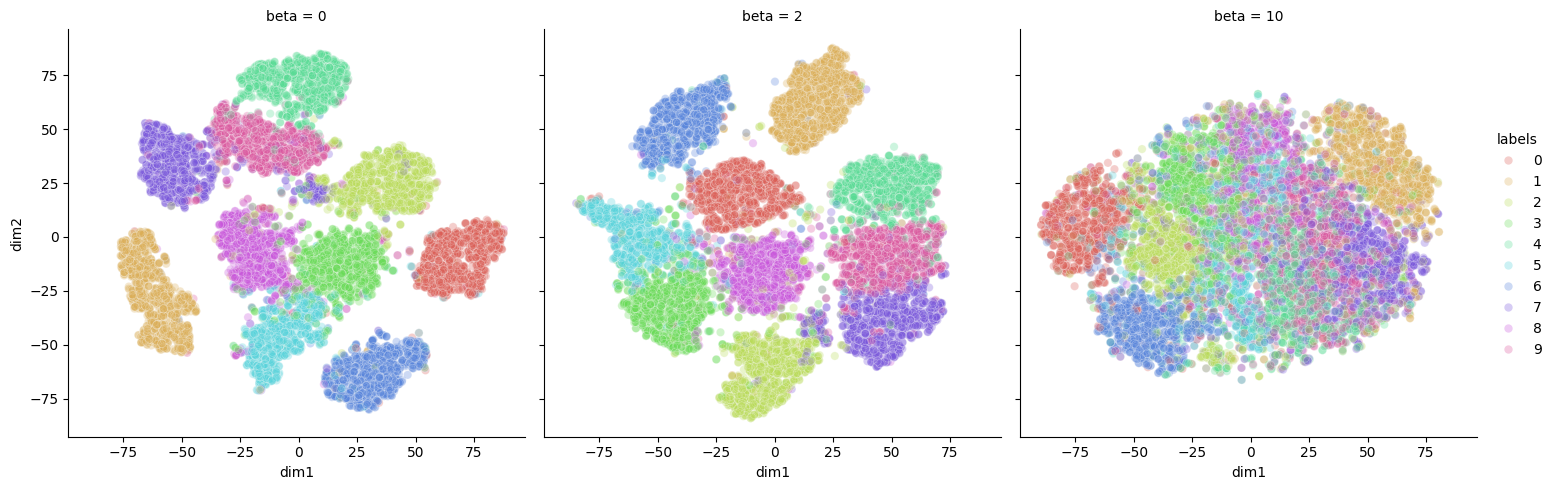

In [97]:
# Custom Visualizations
sns.relplot(learned_representations, x="dim1", y="dim2", hue="labels", 
            palette=sns.color_palette("hls", 10), alpha = 0.3, col='beta')

### Discussion
What do you observe? Discuss the structure of the visualized representations. 
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters

* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

Note - If you created multiple plots and want to include them in your discussion, the best option is to upload them to (e.g.) google drive and then embed them via a **public** share link. If you reference local files, please include these in your submission zip, and use relative pathing if you are embedding them (with the notebook in the base directory)

**YOUR ANSWER**

I show three plots of the latent representations for different values of beta.  At the other end of the spectrum, at beta = 10 we put a very heavy weight on KLD. 

At beta=0, we only care about the reconstruction loss. Here the labels are all highly separated; there is large sparcity in the latent space and outliers are few and far between. This shows a highly effective encoding, but it will come at the cost of poor generative performance.

At the other end of the extreme, we can see that with a high beta, we witness posterior collapse as the latent representation is coerced into a standard normal distribution (we can also observe that the shape of latent representations conforms to a circle which is how a normal distribution looks in 2D).

Considering the middle plot where beta = 2, my chosen parameter value, it appears that the model manages to efficiently reconstruct the inputs, as each colour is grouped within one region, although there is some overlap between the labels. The latent space is sparse between the regions which represent the different numbers which is a good sign. 

Regarding the reliability of the T-SNE, in the original paper, the authors claim that "the performance of T-SNE is fairly robust to changes in perplexity, and typical values are between 5 and 50". By default, the implementation above uses a perplexity of 30. However, as the blog linked above shows, even perplexity choices within this range can lead to significantly different results. The number of steps can also lead to large differences, and counterintuitively it appears other hyperparamters matter very little, such as cluster sizes. All this suggests that multiple T-SNE plots with varying hyperparameters will help give a better overall picture than just one.

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

_hint: Locate the positions in latent space of 2 data points (maybe a one and an eight). Then sample multiple latent space vectors along the line which joins the 2 points and pass them through the decoder._


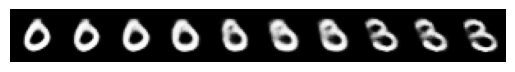

In [107]:
# CODE FOR PART 1.3b IN THIS CELL

test_dataloader = DataLoader(test_dat, 10000, shuffle=False)

# Step 1: Find instances of two specific digits in the dataset

def find_digits(dataloader, digit1, digit2):
    
    data_point_1 = None
    data_point_2 = None
    
    for images, labels in dataloader:
        if data_point_1 is None:
            indices_1 = (labels == digit1).nonzero(as_tuple=True)[0]
            if len(indices_1) > 0:
                data_point_1 = images[indices_1[0]].unsqueeze(0)
                
        if data_point_2 is None:
            indices_2 = (labels == digit2).nonzero(as_tuple=True)[0]
            if len(indices_2) > 0:
                data_point_2 = images[indices_2[0]].unsqueeze(0)
        
        if data_point_1 is not None and data_point_2 is not None:
            break # avoid searching for any more data points
        
    return data_point_1, data_point_2

data_point_1, data_point_2 = find_digits(test_dataloader, 0, 3)

# Step 2: Encode to obtain latent representations, interpolate, then decode 

def interpolate_latent_space(model, data1, data2, steps=10, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    data1 = data1.to(device)
    data2 = data2.to(device)
    mu1, logvar1 = model.encode(data1)
    mu2, logvar2 = model.encode(data2)

    # Linear interpolation in latent space
    interpolated_images = []
    for i in np.linspace(0, 1, steps):
        mu = (1 - i) * mu1 + i * mu2
        logvar = (1 - i) * logvar1 + i * logvar2
        z = model.reparametrize(mu, logvar)

        with torch.no_grad():
            reconstructed = model.decode(z).cpu()
            interpolated_images.append(reconstructed)

    return interpolated_images

interpolated_images = interpolate_latent_space(model, data_point_1, data_point_2, steps=10, device=device)

# Step 3: Plot

def plot_interpolation(interpolated_images, nrow=10):
    images_tensor = torch.cat(interpolated_images, 0)
    grid_img = make_grid(images_tensor, nrow=nrow)
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    
plot_interpolation(interpolated_images)


### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

The interpolation is broadly in line with what I expected - a gradual shift from a zero to three. I chose these digits because, from my T-SNE plot, it would force the latent representations to pass through the space occupied by eight, and indeed you can see something of this in the middle pictures where the zero shifts more to an eight, and then from an eight to a three. 

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to load and run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

## Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. 

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [155]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

#mean = torch.Tensor([0.4914, 0.4822, 0.4465])
#std = torch.Tensor([0.247, 0.243, 0.261])
mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):
    
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small kernels, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [156]:
batch_size =  200 # as in the original paper
image_size = 32
transform = transforms.Compose([
     transforms.Resize(image_size),
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),                        
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set: 

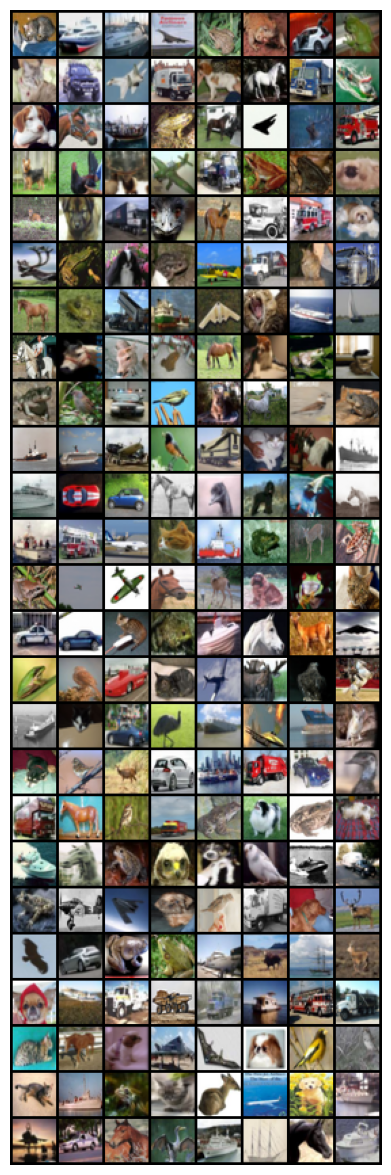

In [157]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [158]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 500
learning_rate = 0.0001
latent_vector_size = 100

# Other hyperparams
# See batch size and image size above 
momentum = 0.5 #for adam optimiser
ngf = 32 #number of ouput filters for G
ndf = 32 # number of output filters for D
nc = 3 #n number of channels - 3 for RGB as usual
out_folder = content_path/'CW_GAN'

In [159]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Architcture inspired from this paper: https://arxiv.org/abs/1606.03498v1

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, ngf * 8, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        return self.main(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
        )
        self.main2 = nn.Sequential(nn.Linear(1024, 10),)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    # You can modify the arguments of this function if needed
    def forward(self, x, matching = False):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.main(x)
        feature = out.view(-1, 1024)
        out = self.main2(feature)
        if matching == True:
            return feature, out
        else:
            return out
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [160]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [161]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 1099712
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)


Total number of paramete

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [162]:
# You can modify the arguments of this function if needed
def loss_function(out, label, criterion):
    out = out.to(device)
    label = label.to(device)
    criterion = criterion.to(device)
    return criterion(out, label)

<h3>Choose and initialize optimizers</h3>

In [163]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(momentum, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(momentum, 0.999))

<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [164]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Additional input variables should be defined here

# Helper functions for the training
def to_scalar(var):
    return var.view(-1).data.tolist()[0]

def argmax(vec):
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def LSE(before_softmax_output):
    # Log sum exp used as a smooth approx of the maximum function
    vec = before_softmax_output
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    output = max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast),1))
    return output

# Initialise other objects for the training loop

# Lists to store losses
train_losses_G = []
train_losses_D = []

# Loss criteria
criterionD = nn.CrossEntropyLoss().to(device) # binary cross-entropy
criterionG = nn.MSELoss().to(device)

# Objects to store data/labels
input = torch.FloatTensor(batch_size, 3, image_size, image_size)
input = input.to(device)
input_label = torch.FloatTensor(batch_size)
noise = torch.FloatTensor(batch_size, latent_vector_size, 1, 1)
noise = noise.to(device)
label = torch.FloatTensor(batch_size)
label = label.to(device)


#### Training Loop

Complete the training loop below. We've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [165]:
for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            # Train with real data
            
            ## Reset gradients to zero
            model_D.zero_grad()
            
            ## Load data and labels
            real_cpu, real_label = data
            batch_size = real_cpu.size(0)
            real_cpu = real_cpu.to(device)
            input.resize_as_(real_cpu).copy_(real_cpu)
            real_cpu = data[0].to(device) # naming given from objects below
            
            ## Semi-supervised learning, so split batch into labelled and unlabelled
            ## Loss calculation for labeled data
            label_input = input[:100]
            unlabel_input = input[100:]
            l_label = real_label[:100] # only keep labels for our labelled subset
            l_output = model_D(label_input)
            loss_label = loss_function(l_output, l_label, criterionD) # Loss 1
            ## Loss calculation for unlabeled real data
            unl_output = model_D(unlabel_input)
            loss_unl_real = -torch.mean(LSE(unl_output), 0) + torch.mean(F.softplus(LSE(unl_output), 1), 0)
            
            # Train with fake data
            noise.resize_(int(batch_size/2), latent_vector_size, 1, 1).normal_(0, 1)
            fake = model_G(noise)
            unl_output = model_D(fake.detach()) # so we don't update G
            loss_unl_fake = torch.mean(F.softplus(LSE(unl_output), 1), 0)
            
            D_G_z1 = unl_output.mean().item()  # Calculate D(G(z)) before updating D
            
            # Calculate loss, do backprop, update params
            errD =  loss_label + loss_unl_real + loss_unl_fake
            errD.backward() # necause of the detach in unl_output this shouldn't update model_G
            optimizerD.step()
            
            D_G_z2 = model_D(fake).mean().item()  # Calculate D(G(z)) after updating D
            
            train_loss_D += errD.item()

            # (2) Update G network: maximize log(D(G(z)))
            model_G.zero_grad()
            ## Note that we do feature matching here
            feature_real, _ = model_D(input.detach(), matching=True)
            feature_fake, output = model_D(fake, matching = True)
            feature_real = torch.mean(feature_real,0)
            feature_fake = torch.mean(feature_fake,0)
            
            errG = loss_function(feature_fake, feature_real.detach(), criterionG)
            train_loss_G += errG.item()
            errG.backward()
            optimizerG.step()
            ####################################################################### 
            #                       ** END OF YOUR CODE **
            ####################################################################### 
            # Logging 
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                D_x = l_output.mean().item()  # Average output for real data in the batch
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
    
# save  models 
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

Epoch 499: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:12<00:00, 20.30batch/s, D_G_z=-18.112/-18.419, D_x=-11.2, Loss_D=0.0121, Loss_G=0.0183]


## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=18aWqRAnAVTRDY52y1yHSCdqSxUFRKOS9" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1ymO2-jGAvWeUR2kaj_LxQcGYF1RWNRnw" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=13SW62ekW32NMYtfcdm_dCJJ3ZMOZEZAJ" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

### Generator samples

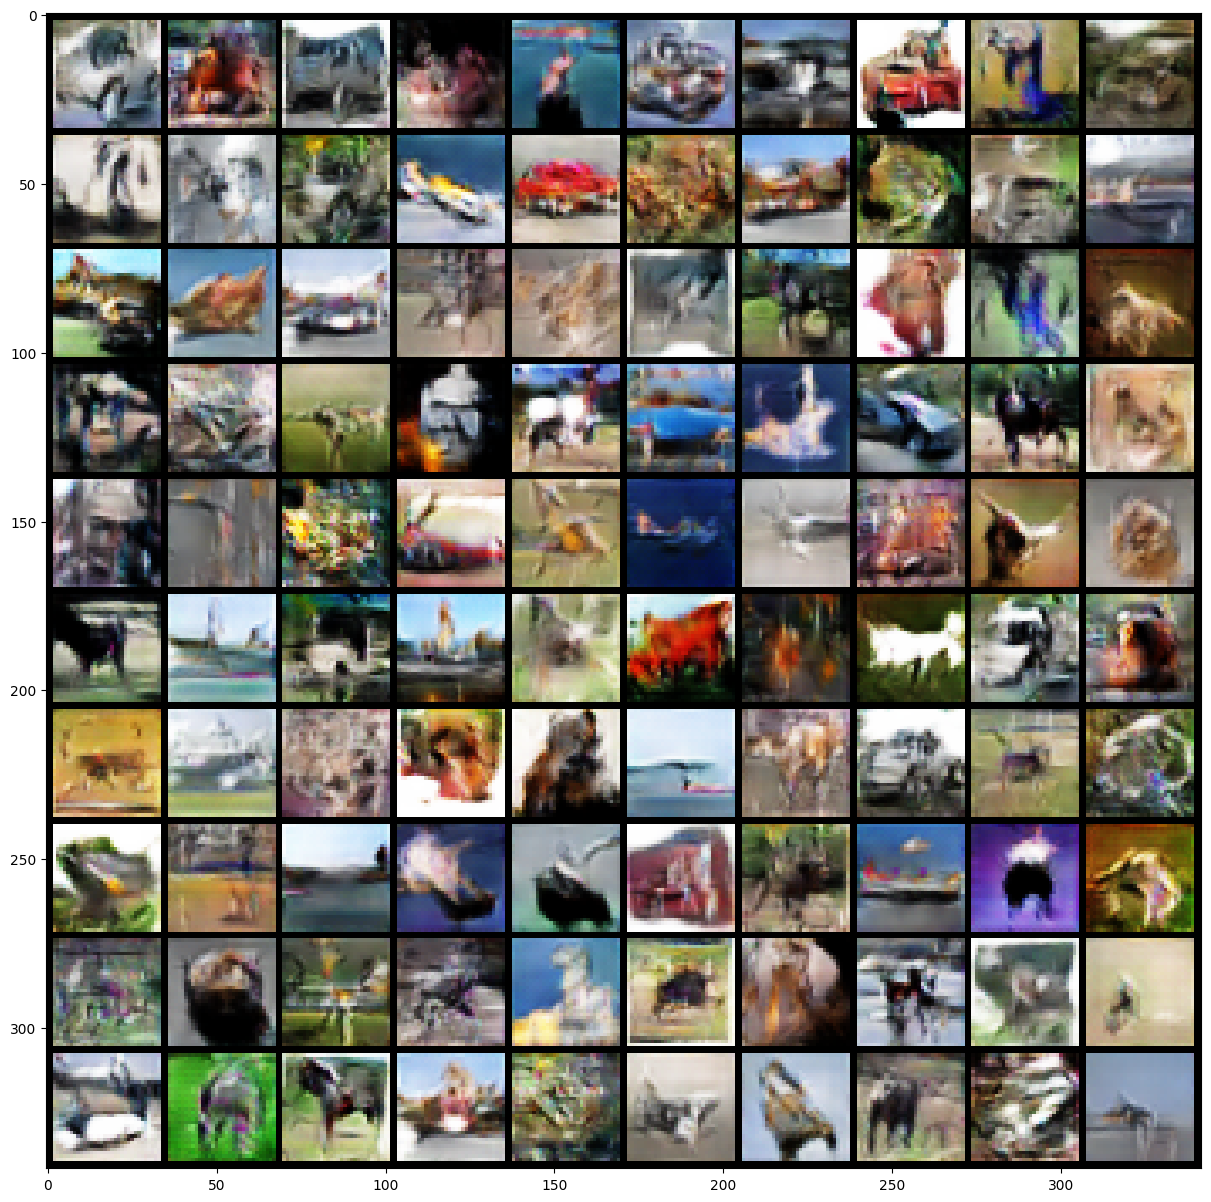

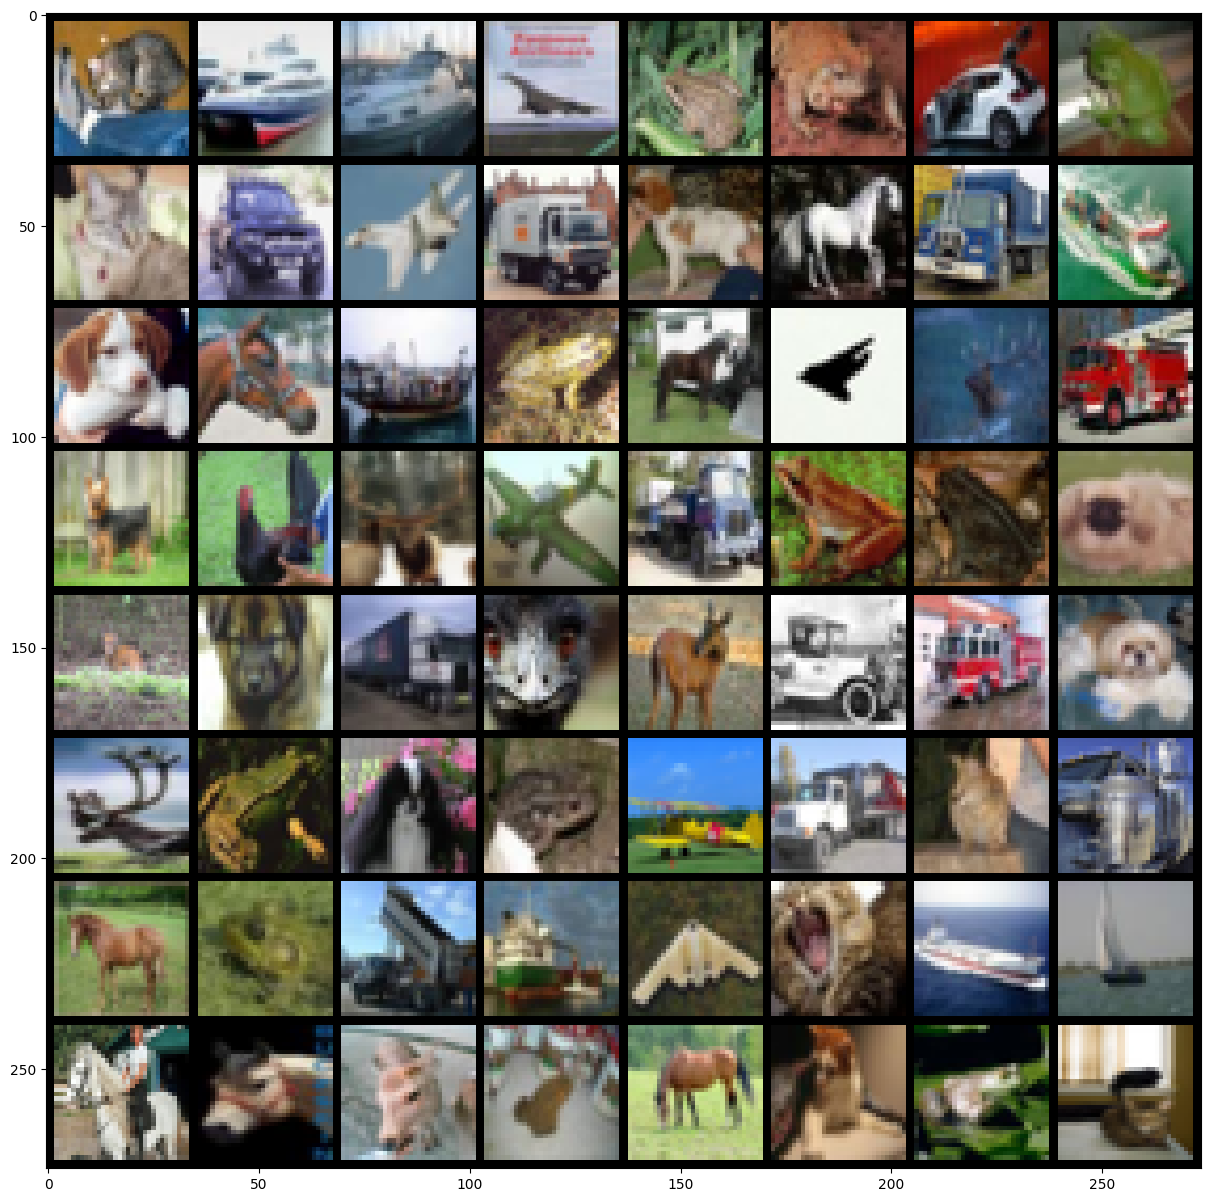

In [166]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**

At first, I implemented the architecture and set the hyperparameters according to the original paper. This includes elements such as batchnorms, convolution transpositions for upsampling and leaky ReLUs for activation functions. While providing a sensible baseline to begin with, one problem I found was that the loss functions were not converging, and that my GAN losses began to climb as epochs increased. Despite altering hyperparameters (e.g. asymmetric learnings rates for the generator and discriminator, changing epochs, batch sizes etc.) I found no meaningful improvement. (To evidence this initial approach, I include the code at the end of the notebook, commented out.)

Consequently, I tried to implement a better architecture. I found the paper "Improved Techniques for Training GANs" by Goodfellow et al. (2016) (see https://arxiv.org/pdf/1606.03498v1.pdf) which offered several novelties to address the stability issues of GAN training. 

First, this led me to a semi-supervised approach (highlighted in the code above by comments). This is where the loss is calculated from both the supervised samples with labels and the unsupervised samples with no labels. In this case, I split the batch of 200 into 100 of each so the total loss is just a simple sum of both components. The aim is to better estimate the optimal solution from the data by minimising these two loss functions jointly (see section 5 of the paper for futher details). In addition, I used a log-sum-exp operation on the loss function to introduce numeric stability. From other machine learning papers I have seen, I believe that this is appropriate to use in the context of log-likelihood calculations for softmax functions in classification tasks. 

The other main innovation I used is feature matching (again, highlighted in the code comments in the training loop). This tries to address instability in GANs by giving the generator a new objective. Rather than the risk of it overtraining on the current discriminator, instead it seeks to generate data that matches the statistics of the real data, and the discriminator is used to specify which statistics are worth matching. In particular, like the authors of the paper I train the generator to match the expected values of the features on an intermediate layer of the discriminator. 

As shown by the loss curves below, this approach appears to have delivered a converging GAN training in which the Nash Equilibrium is stable. 

Finally, a note that I also used the tanh() activation function but without normalising my pixels to be between the range of -1 and 1. As many pixels had a value of above 1, my generated images came out rather grey and dim. To solve this, I redefined the mean and std torch tensors to repeats of 0.5 which standardised the pixel values. This ensured a good saturation. I did also try removing the tanh() activation altogether, but then I had the opposite problem of over-saturation relative to the original images. 

One trick I came across in the original paper which I would have liked to try, but which I didn't have time to, is deduplication. This is to decrease the likelihood that the generator simply memorising the input examples. However, the process to do this isn't straightforward and I was satisfied with the generative properties of my output images for the purposes of this exercise. 

## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

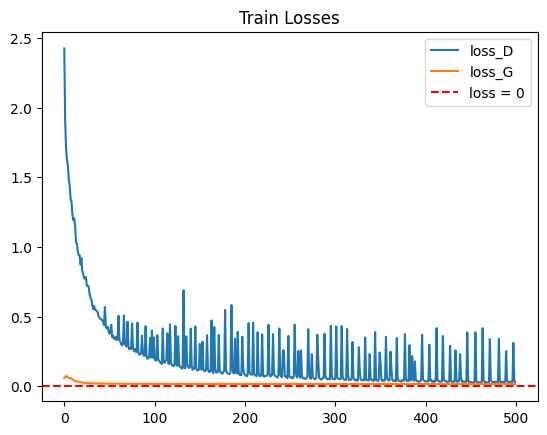

In [185]:
# ANSWER FOR PART 2.2 IN THIS CELL*

plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.axhline(y=0.0, color='r', linestyle='--', label='loss = 0')
plt.legend()
plt.title('Train Losses')
plt.show()

### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

As mentioned above, my previous loss curves looked quite different. My generator loss started high, fell, but then increased as the epochs continued. By contrast, here the generator loss is low, but that is because I have redefined the generator loss function (see above cell for discussion). Happily, the discriminator loss falls steadily over time, although it a little spiky, it still converges towards zero, along with the generative loss. This suggests to me that the efforts made to change the architecture of the model to ensure that the GAN training converges on a stable solution in which both G and D minimise losses has worked. 

## Part 2.3: Understanding Mode Collapse (5 points) 
**Your task:**
 
Describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN. 

Based on the images created by your generator using the `fixed_noise` vector during training, did you notice any mode collapse? what this behaviour may be attributed to, and what did you try to eliminate / reduce it?

### Discussion


**YOUR ANSWER**

Mode collapse in GAN occurs when the generator learns to produce a limit variety of outputs. I did not notice it in my final implementation, but to identify the impact of the hyperparameters, in one instance I reduced the latent dimensions to 2, down from 100. I believe that this left the discriminator with too few parameters, getting stuck on local minima when trying to classify on a very limited number of features. As a response to this, the generator learnt to generate very similar images over and over again based on a sample number of features. In that particular case, I saw lots of images with a black blob in the middle, which looked something like a sleeping cat. 

To avoid this, I ensured a rich latent space with a high number of dimensions as well as a high enough learning rate so that the discriminator can keep learning and not get fooled by repeated outputs from the generative model. As my generated images look sufficiently different from each other, I believe that my implementation produces no evidence of mode collapse.



# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably. 

<font color="orange"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [186]:
# If you want to run these tests yourself, change directory:
# %cd '.../dl_cw2/'
if True: # for my own testing
    %cd '../../../../../vol/bitbucket/mdh323/dl/dl_cw2'
    ta_data_path = data_path
else:
    ta_data_path = "../data" # You can change this to = data_path when testing

/vol/bitbucket/mdh323/dl/dl_cw2


/vol/bitbucket/mdh323/myenv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [187]:
!pip install -q torch torchvision

In [188]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt 

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [189]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.round(),
])


def vae_denorm(x):
    return x


def gan_denorm(x, channels=None, w=None ,h=None, resize = False):
    
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

gan_latent_size = 100

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [190]:
# Load VAE Dataset
test_dat = datasets.MNIST(ta_data_path, train=False, transform=vae_transform, 
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [191]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

Used CNN


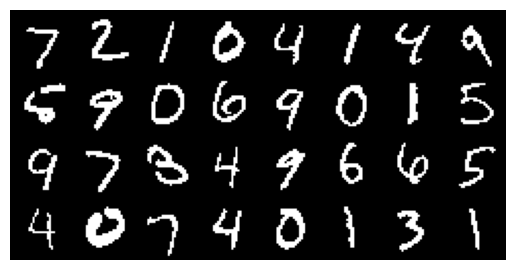

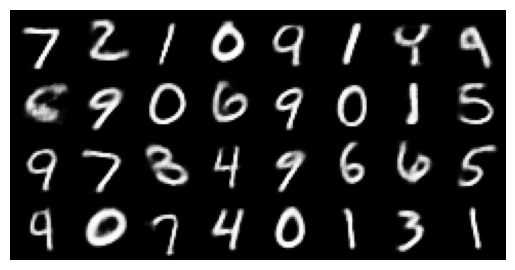

In [192]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if 'weight' in params.keys():
            flag = params['weight'].ndim == 4
    return flag

has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

Number of Parameters is 1800522 which is ok


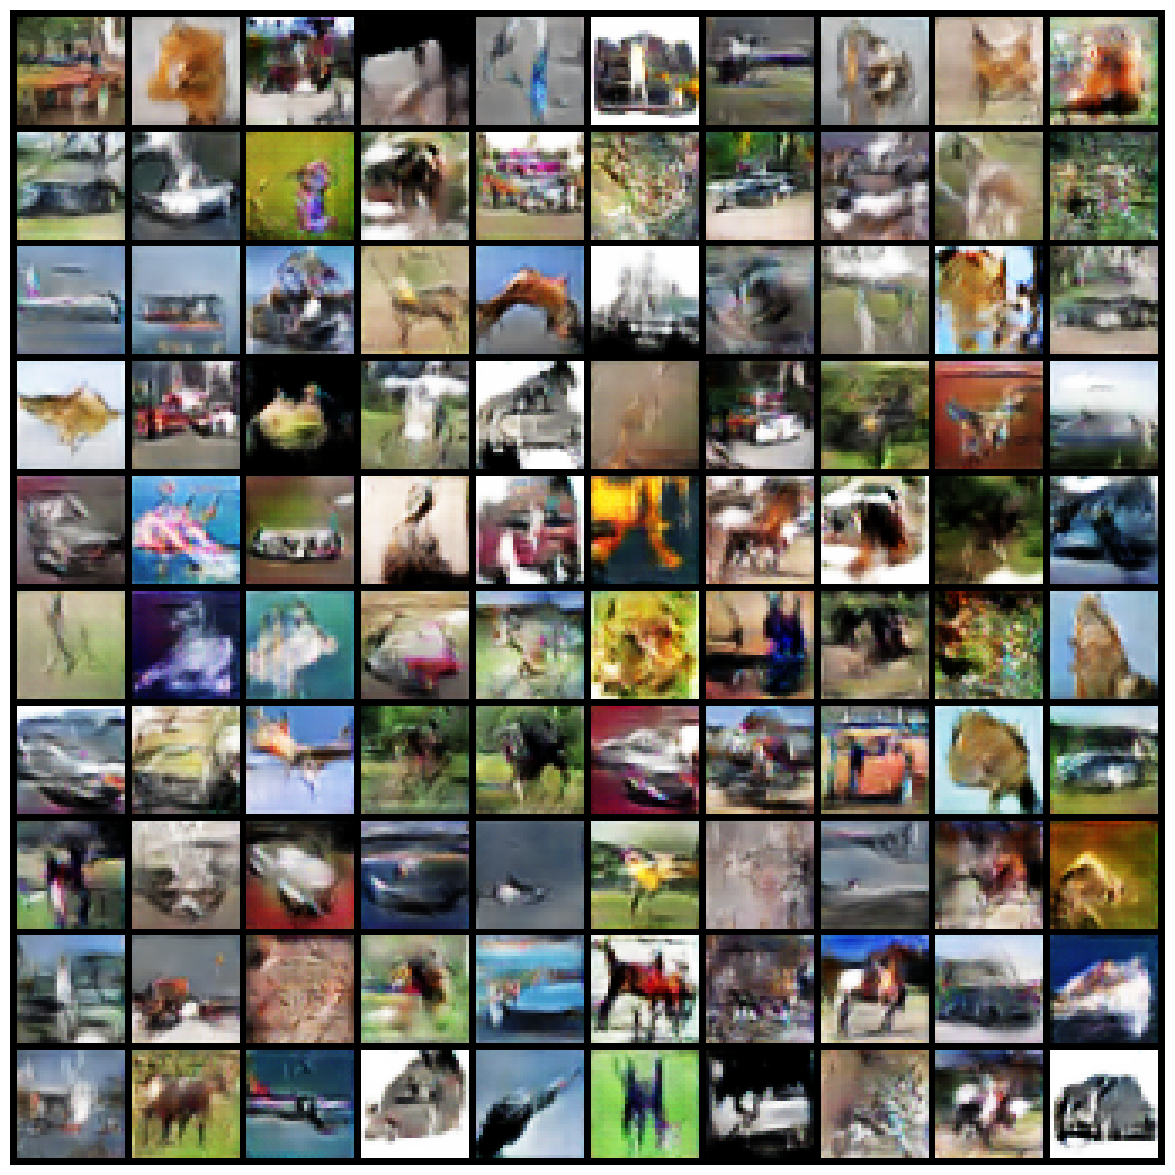

In [193]:
# GAN Tests
model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]  

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:100].detach(), nrow=10, padding=2, normalize=False, 
                    value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)

In [ ]:
# My initial attempt using the model specified in the original GAN paper. Here I include the model and training loop.

# Architcture is taken difrectly from the paper, esp. p3

# class Generator(nn.Module):
#     def __init__(self, latent_vector_size):
#         super(Generator, self).__init__()
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         self.latent_vector_size = latent_vector_size # Size of the noise vector. In original paper this is 100.
#         self.main = nn.Sequential(
            
#             nn.ConvTranspose2d(latent_vector_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
            
#             nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
            
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
            
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
            
#             nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.Tanh()
#             # Output channels = 3 due to RGB
#         )
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 

#     # You can modify the arguments of this function if needed
#     def forward(self, z):
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         return self.main(z)
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         #######################################################################



# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         self.main = nn.Sequential(
            
#             nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
#             nn.Sigmoid()
#         )
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 
        
#     # You can modify the arguments of this function if needed
#     def forward(self, x):
#         #######################################################################
#         #                       ** START OF YOUR CODE **
#         #######################################################################
#         out = self.main(x)
#         return out.view(-1, 1).squeeze(1)
#         #######################################################################
#         #                       ** END OF YOUR CODE **
#         ####################################################################### 
        
#     # Initialise lists to store losses
# train_losses_G = []
# train_losses_D = []


# for epoch in range(num_epochs):
#     train_loss_D = 0
#     train_loss_G = 0
#     with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
#         for i, data in enumerate(tepoch):
            
#             #######################################################################
#             #                       ** START OF YOUR CODE **
#             #######################################################################
#             # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

#             # train with real
#                 # Setup
#             model_D.zero_grad()
#             real_cpu = data[0].to(device) # naming given from objects below
#             b_size = real_cpu.size(0)
#             label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            
#                 # Train
#             output = model_D(real_cpu)
#             errD_real = loss_function(output, label)
#             errD_real.backward()
#             D_x = output.mean().item()


#             # train with fake
#                 # Setup
#             # Much like fixed noise above
#             noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
#             fake = model_G(noise)
#             label.fill_(fake_label)
            
#                 # Train
#             output = model_D(fake.detach())
#             errD_fake = loss_function(output, label)
#             errD_fake.backward()
#             errD = errD_real + errD_fake
#             train_loss_D += errD.item()
#             optimizerD.step()
            
#             # (2) Update G network: maximize log(D(G(z)))
#             model_G.zero_grad()
#             label.fill_(real_label)
#             output = model_D(fake)
#             errG = loss_function(output, label)
#             errG.backward()
#             train_loss_G += errG.item()
#             optimizerG.step()
#             ####################################################################### 
#             #                       ** END OF YOUR CODE **
#             ####################################################################### 
#             # Logging 
#             if i % 50 == 0:
#                 tepoch.set_description(f"Epoch {epoch}")
#                 tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
#                                   Loss_D=errD.item(), Loss_G=errG.item())

#     if epoch == 0:
#         save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
#     with torch.no_grad():
#         fake = model_G(fixed_noise)
#         save_image(denorm(fake.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
#     train_losses_D.append(train_loss_D / len(loader_train))
#     train_losses_G.append(train_loss_G / len(loader_train))
    
# # save  models 
# # if your discriminator/generator are conditional you'll want to change the inputs here
# torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
# torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')